In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
# DOWNLOADING DEL DATASET
!gdown 1aWKik15N2up5DUiZsHim_tt-SIqzmrhj

Downloading...
From: https://drive.google.com/uc?id=1aWKik15N2up5DUiZsHim_tt-SIqzmrhj
To: /content/CityScapes_fusion.zip
100% 1.28G/1.28G [00:14<00:00, 89.1MB/s]


In [3]:
!unzip CityScapes_fusion

Archive:  CityScapes_fusion.zip
   creating: CityScapes_fusion/CityMask/
  inflating: CityScapes_fusion/CityMask/aachen_000000_000019_gtFine_instanceIds.png  
  inflating: CityScapes_fusion/CityMask/aachen_000001_000019_gtFine_instanceIds.png  
  inflating: CityScapes_fusion/CityMask/aachen_000002_000019_gtFine_instanceIds.png  
  inflating: CityScapes_fusion/CityMask/aachen_000003_000019_gtFine_instanceIds.png  
  inflating: CityScapes_fusion/CityMask/aachen_000004_000019_gtFine_instanceIds.png  
  inflating: CityScapes_fusion/CityMask/aachen_000005_000019_gtFine_instanceIds.png  
  inflating: CityScapes_fusion/CityMask/aachen_000006_000019_gtFine_instanceIds.png  
  inflating: CityScapes_fusion/CityMask/aachen_000007_000019_gtFine_instanceIds.png  
  inflating: CityScapes_fusion/CityMask/aachen_000008_000019_gtFine_instanceIds.png  
  inflating: CityScapes_fusion/CityMask/aachen_000009_000019_gtFine_instanceIds.png  
  inflating: CityScapes_fusion/CityMask/aachen_000010_000019_gtFine

In [4]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self , images , masks):
        self.imgs = images
        self.masks = masks

    def __getitem__(self , idx):
        img = Image.open("/content/CityScapes_fusion/PNGImages/" + self.imgs[idx]).convert("RGB")
        mask = Image.open("/content/CityScapes_fusion/CityMask/" + self.masks[idx])
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        #for i in range(num_objs):
        #    masks[i][mask == i+1] = True

        # Lista per tenere traccia delle label che soddisfano la condizione
        valid_labels = []
        boxes = []

        i = 0
        for o in obj_ids:
            masks[i][mask == o] = True
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            # Verifica se larghezza e altezza sono positive
            if xmax > xmin + 1 and ymax > ymin + 1:
                boxes.append([xmin, ymin, xmax, ymax])
                #print(f"Il valore della variabile num_obj è: {i}")
                valid_labels.append(o)

            i = i + 1

        # Usa solo le label valide
        obj_ids = valid_labels


        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        #labels = torch.ones((num_objs,) , dtype = torch.int64)

        labels = []

        # Scansiona la lista obj_ids
        for obj_id in obj_ids:
            # Verifica se il numero è maggiore di 1000
            if obj_id > 1000:
                # Esegui la divisione senza resto per 1000 e aggiungi il risultato a labels
                label = obj_id // 1000
                labels.append(label)
            else:
                # Se il numero è minore o uguale a 1000, aggiungi direttamente a labels
                labels.append(obj_id)

        labels = torch.tensor(labels, dtype=torch.int64)

        masks = torch.as_tensor(masks , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        #alla fine restituisce:
        # - l'immagine convertita in tensore
        # - target
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.imgs)

In [5]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
print(model)
#va modificata solo la parte del modello indicata con:
# -box_predictor (che è FastRCNNPredictor con infeature 1024 e outfeature 91 nella sezione cls_score, cioè prevedeva 91 classi)
#va rimosso e sostituito con uno nuovo

#ci calcoliamo il numero di in_festure del layer prima di rimuoverlo (1024)
in_features = model.roi_heads.box_predictor.cls_score.in_features
#definiamo il nuovo layer
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 34)   #2
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
#va cambiato anche il MaskRCNNPredictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 34)   #2

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 132MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [6]:
transform = T.ToTensor()

In [7]:
#prende i dati e li restituisce nel formato desiderato
def custom_collate(data):
  return data

In [8]:
#divisione del Dataset: in 80% (training) e 20% (Validation)

images = sorted(os.listdir("/content/CityScapes_fusion/PNGImages"))
masks = sorted(os.listdir("/content/CityScapes_fusion/CityMask"))
num = int(0.7 * len(images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
val_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images)[train_imgs_inds]
val_imgs = np.array(images)[val_imgs_inds]
train_masks = np.array(masks)[train_imgs_inds]
val_masks = np.array(masks)[val_imgs_inds]

In [9]:
train_dl = torch.utils.data.DataLoader(CustDat(train_imgs , train_masks) ,
                                 batch_size = 6 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat(val_imgs , val_masks) ,
                                 batch_size = 12 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [12]:
params = [p for p in model.parameters() if p.requires_grad]

In [13]:
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [ ]:

#from numba import cuda
#Pulizia ram e cache delle GPU

#torch.cuda.empty_cache()
#device = cuda.get_current_device()
#device.reset()

In [14]:

train_epoch_loss_cl = []
train_epoch_loss_bb=[]
train_epoch_loss_mask=[]
val_epoch_loss_cl = []
val_epoch_loss_bb=[]
val_epoch_loss_mask=[]
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(20):
    loss_classifier=0
    loss_bb=0
    loss_mask=0
    loss_classifier_val=0
    loss_bb_val=0
    loss_mask_val=0
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()

    for i, dt in enumerate(train_dl):
        imgs = [img[0].to(device) for img in dt]
        targ = [lbl[1] for lbl in dt]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs, targets)

        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        loss_classifier+=loss["loss_classifier"].item()
        loss_bb+=loss["loss_box_reg"].item()
        loss_mask+=loss["loss_mask"].item()
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    train_epoch_loss_cl.append(loss_classifier)
    train_epoch_loss_bb.append(loss_bb)
    train_epoch_loss_mask.append(loss_mask)
    all_train_losses.append(train_epoch_loss)

    with torch.no_grad():
        for j, dt in enumerate(val_dl):
            imgs = [img[0].to(device) for img in dt]
            targ = [lbl[1] for lbl in dt]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs, targets)
            loss_classifier_val+=loss["loss_classifier"].item()
            loss_bb_val+=loss["loss_box_reg"].item()
            loss_mask_val+=loss["loss_mask"].item()
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()

        val_epoch_loss_cl.append(loss_classifier_val)
        val_epoch_loss_bb.append(loss_bb_val)
        val_epoch_loss_mask.append(loss_mask_val)
        all_val_losses.append(val_epoch_loss)

    print(epoch, "total train loss", train_epoch_loss, "total val loss", val_epoch_loss)
    print(epoch, "loss classifier train: ", loss_classifier, "loss classifier val: ", loss_classifier_val)
    print(epoch, "loss bb train: ", loss_bb, "loss bb val: ", loss_bb_val)
    print(epoch, "loss mask train: ", loss_mask, "loss mask val: ", loss_mask_val)

{'loss_classifier': tensor(3.7400, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.8895, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(1.1250, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(1.2884, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.4921, device='cuda:0', grad_fn=<DivBackward0>)}
0 total train loss 193.18578505516052 total val loss 33.07974910736084
0 loss classifier train:  67.19657933712006 loss classifier val:  9.35313469171524
0 loss bb train:  47.012872874736786 loss bb val:  8.964978218078613
0 loss mask train:  41.303816586732864 loss mask val:  7.455698013305664
1 total train loss 141.33937406539917 total val loss 29.933839321136475
1 loss classifier train:  39.565113455057144 loss classifier val:  8.003577649593353
1 loss bb train:  38.85207325220108 loss bb val:  8.179818272590637
1 loss mask train:  32.021018117666245

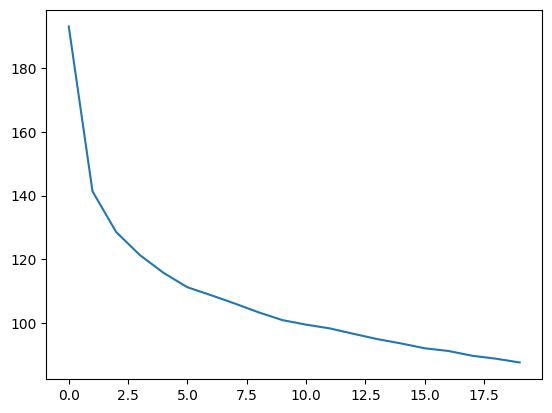

In [15]:
plt.plot(all_train_losses)

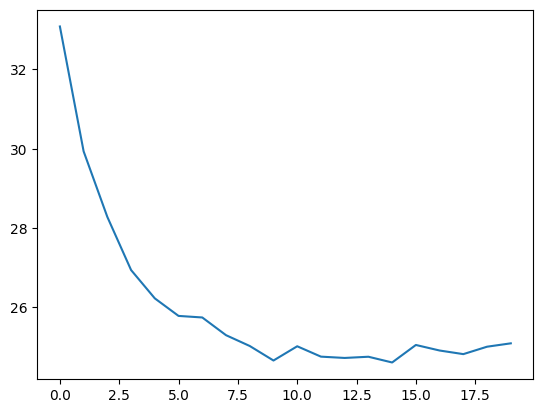

In [16]:
plt.plot(all_val_losses)

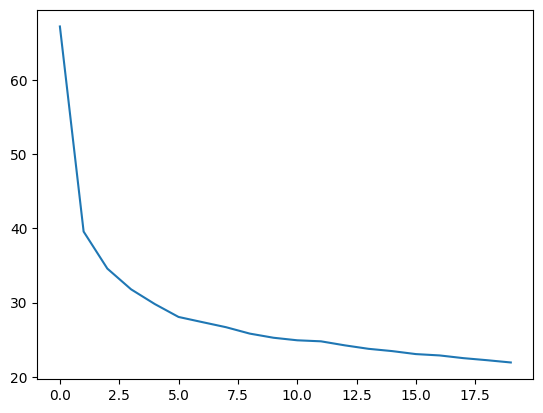

In [17]:
plt.plot(train_epoch_loss_cl)

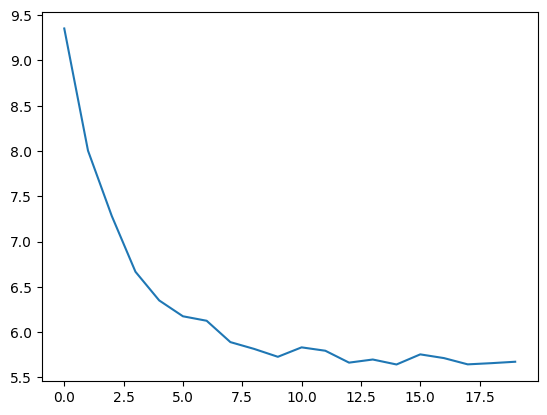

In [18]:
plt.plot(val_epoch_loss_cl)

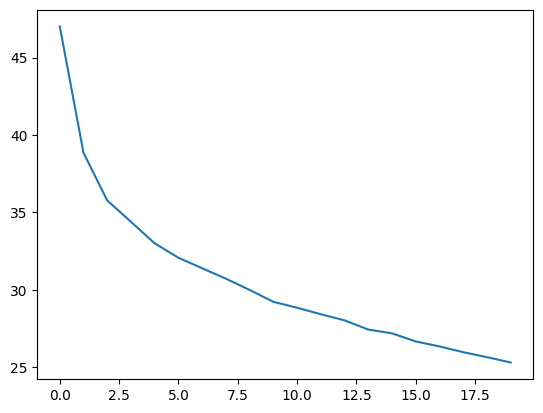

In [19]:
plt.plot( train_epoch_loss_bb)

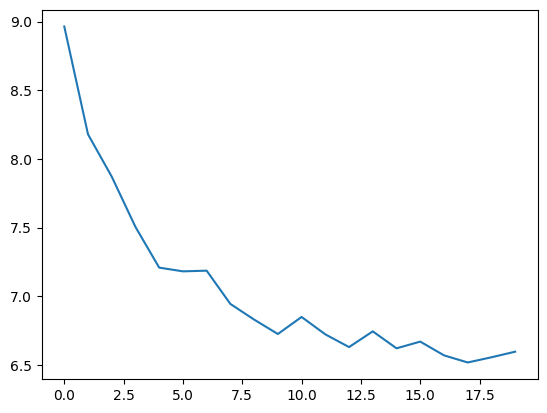

In [20]:
plt.plot(val_epoch_loss_bb)

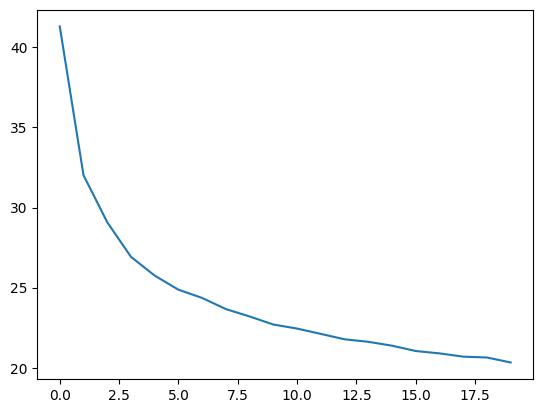

In [21]:
plt.plot(train_epoch_loss_mask)

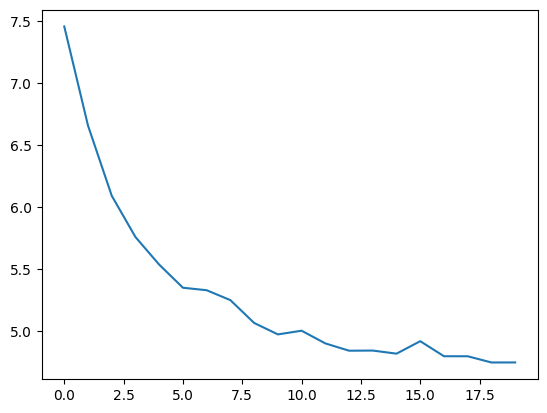

In [22]:
plt.plot(val_epoch_loss_mask)

Labels: ['car: 0.999', 'car: 0.998', 'person: 0.990', 'sky: 0.973', 'road: 0.916', 'bicycle: 0.910', 'rider: 0.895', 'person: 0.843', 'car: 0.825', 'ego vehicle: 0.768', 'person: 0.529', 'pole: 0.523', 'car: 0.522', 'car: 0.419', 'car: 0.407', 'sidewalk: 0.384', 'building: 0.372', 'vegetation: 0.344', 'vegetation: 0.286', 'car: 0.278', 'motorcycle: 0.272', 'rider: 0.267', 'bicycle: 0.258', 'static: 0.254', 'person: 0.247', 'person: 0.224', 'sidewalk: 0.223', 'pole: 0.221', 'car: 0.213', 'traffic sign: 0.200', 'traffic light: 0.188', 'static: 0.185', 'parking: 0.173', 'building: 0.170', 'traffic sign: 0.164', 'person: 0.159', 'terrain: 0.155', 'traffic sign: 0.153', 'terrain: 0.149', 'vegetation: 0.148', 'parking: 0.145', 'sidewalk: 0.140', 'traffic sign: 0.137', 'rider: 0.134', 'building: 0.121', 'rectification border: 0.117', 'traffic light: 0.112', 'car: 0.108', 'person: 0.108', 'static: 0.107', 'person: 0.105', 'motorcycle: 0.105', 'static: 0.102', 'person: 0.101', 'sidewalk: 0.101'

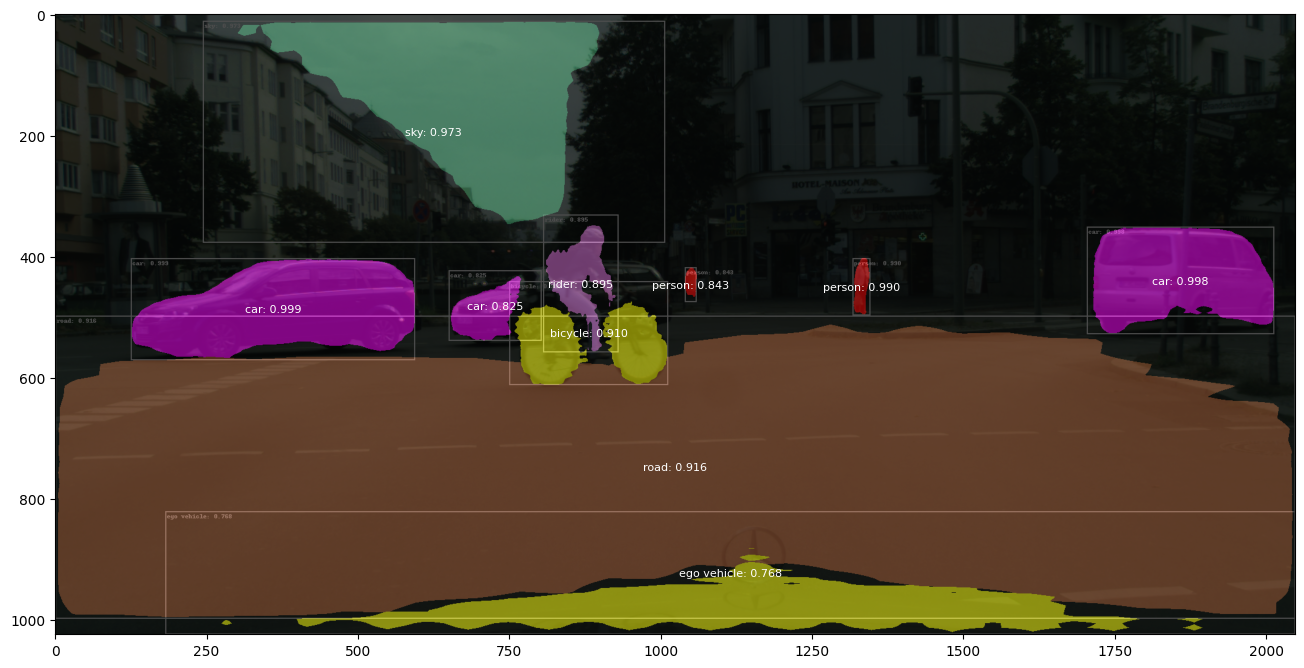

In [36]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from PIL import Image


image = read_image("/content/berlin_000003_000019.png")
model.eval()
img = Image.open("/content/berlin_000003_000019.png")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

# Crea un dizionario per mappare label a nome della classe
label_to_class = {
    0: 'unlabeled',
    1: 'ego vehicle',
    2: 'rectification border',
    3: 'out of roi',
    4: 'static',
    5: 'dynamic',
    6: 'ground',
    7: 'road',
    8: 'sidewalk',
    9: 'parking',
    10: 'rail track',
    11: 'building',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    15: 'bridge',
    16: 'tunnel',
    17: 'pole',
    18: 'polegroup',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    29: 'caravan',
    30: 'trailer',
    31: 'train',
    32: 'motorcycle',
    33: 'bicycle',
}

# Sostituisci label con il nome della classe nelle pred_labels
pred_labels = [f"{label_to_class[label.item()]}: {score:.3f}" for label, score in zip(pred[0]['labels'], pred[0]['scores'])]


# Stampa i risultati
print("Labels:", pred_labels)

label_to_color = {
    0: 'black',
    1: 'yellow',                    #'darkslategray',red
    2: 'green',
    3: 'blue',
    4: 'purple',
    5: 'orange',
    6: 'cyan',
    7: 'sienna',                    #'magenta',
    8: 'darkolivegreen',            #'yellow',
    9: 'brown',
    10: 'pink',
    11: 'teal',
    12: 'lavender',
    13: 'maroon',
    14: 'olive',
    15: 'navy',
    16: 'gray',
    17: 'gold',
    18: 'indigo',
    19: 'peru',
    20: 'darkorange',
    21: 'darkcyan',
    22: 'lightcoral',
    23: 'seagreen',
    24: 'red',                        #'darkslategray',
    25: 'orchid',
    26: 'magenta',                    #'sienna',
    27: 'royalblue',
    28: 'saddlebrown',
    29: 'mediumvioletred',
    30: 'darkgreen',
    31: 'darkorchid',
    32: 'darkmagenta',
    33: 'yellow',                     #'darkolivegreen',
}

colors = [label_to_color[label.item()] for label in pred[0]['labels']]

pred_boxes = (pred[0]["boxes"].long())
#print(pred_boxes)


#pred_boxes_selection=[]
#i=0
#for score in pred[0]["scores"]:
#  if score>= 0.7:
#    pred_boxes_selection.append(pred[0]["boxes"][i].long())
#  i=i+1

# Seleziona solo i box con score maggiore o uguale a 0.7
selected_indices = [i for i, score in enumerate(pred[0]["scores"]) if score >= 0.53]
pred_boxes_selection = pred_boxes[selected_indices]
selected_labels = [pred_labels[i] for i in selected_indices]


#pred_boxes_selection = torch.stack(pred_boxes_selection)
# Crea l'immagine con i bounding boxes
#output_image = draw_bounding_boxes(image,pred_boxes_selection, pred_labels, colors="red")
output_image = draw_bounding_boxes(image, pred_boxes_selection, selected_labels, colors="white", width=2)

# Imposta la dimensione del testo con Matplotlib
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(output_image.permute(1, 2, 0))

# Itera sui bounding boxes e etichette per aggiungere il testo con dimensione personalizzata
#for box, label, color in zip(pred_boxes_selection, pred_labels, colors):
for box, label, color in zip(pred_boxes_selection, selected_labels, colors):
    xmin, ymin, xmax, ymax = box
    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2

    # Aggiungi il testo con dimensione personalizzata
    #ax.text(center_x, center_y, label, fontsize=8, color=color, ha="center", va="center")
    ax.text(center_x, center_y, label, fontsize=8, color="white", ha="center", va="center")

# Visualizza le maschere di segmentazione con i colori
#masks = (pred[0]["masks"] > 0.7).squeeze(1)
#print(masks.type())
# Visualizza le maschere di segmentazione con i colori
# Visualizza le maschere di segmentazione con i colori
# Visualizza le maschere di segmentazione con i colori

selected_masks = [pred[0]["masks"][i]>0.55 for i in selected_indices]
pred_masks = torch.stack(selected_masks).squeeze(1)  # Rimuovi la dimensione del canale


print(pred_masks.type())
colors = [label_to_color[label.item()] for label in pred[0]['labels']]
segmentation_masks = draw_segmentation_masks(torch.zeros_like(image), pred_masks, alpha=0.7, colors=colors)





# Sovrapponi la mappa di segmentazione all'immagine
ax.imshow(segmentation_masks.permute(1, 2, 0), alpha=0.7)

plt.show()

In [34]:
def get_prediction(img_path, threshold=0.5, url=False):

  img = Image.open(img_path) # This is for local images
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  #Let's change it to GPU
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  label_to_class = {
    0: 'unlabeled',
    1: 'ego vehicle',
    2: 'rectification border',
    3: 'out of roi',
    4: 'static',
    5: 'dynamic',
    6: 'ground',
    7: 'road',
    8: 'sidewalk',
    9: 'parking',
    10: 'rail track',
    11: 'building',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    15: 'bridge',
    16: 'tunnel',
    17: 'pole',
    18: 'polegroup',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    29: 'caravan',
    30: 'trailer',
    31: 'train',
    32: 'motorcycle',
    33: 'bicycle',
}

# Sostituisci label con il nome della classe nelle pred_labels


  pred_class = [label_to_class[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [35]:
import cv2 # opencv
import random
def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask


In [48]:


def instance_segmentation(img_path, threshold=0.53, rect_th=3, text_size=1, text_th=3, url=False, figsize=(16, 16)):
    masks, boxes, pred_cls = get_prediction(img_path, threshold=threshold, url=url)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # For working with RGB images instead of BGR
    img = cv2.resize(img, figsize, interpolation=cv2.INTER_LINEAR)  # Resize image

    for i in range(len(masks)):
        rgb_mask = random_color_masks(masks[i])
        rgb_mask = cv2.resize(rgb_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)  # Resize colored mask
        img = cv2.addWeighted(img, 1, rgb_mask, 0.45, 0)
        pt1 = tuple(int(x) for x in boxes[i][0])
        pt2 = tuple(int(x) for x in boxes[i][1])
        cv2.rectangle(img, pt1, pt2, color=(255, 255, 255), thickness=rect_th)
        cv2.putText(img, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (255, 255, 255), thickness=text_th)

    return img, pred_cls, masks[i]



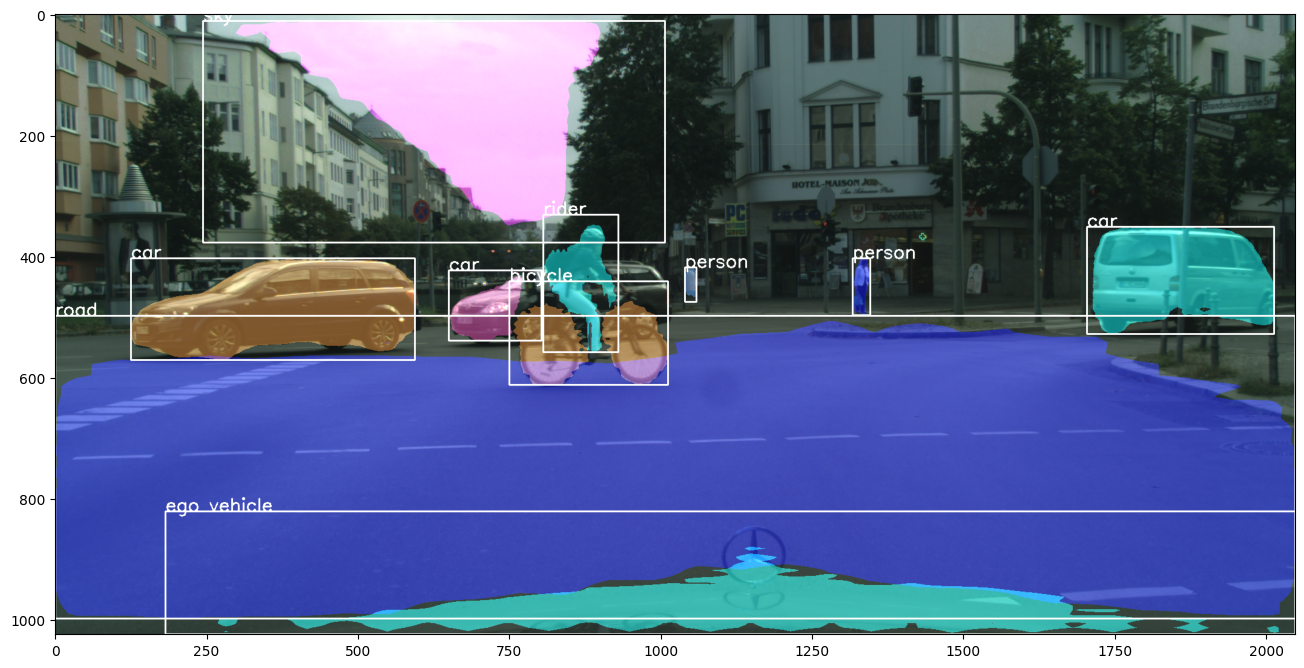

In [49]:

img, pred_classes, masks = instance_segmentation('/content/berlin_000003_000019.png', rect_th=2, text_th=2, figsize=(2048, 1024))
# Imposta la dimensione del testo con Matplotlib
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(img)

